In [ ]:
import torch
import cv2
import time
import os
import glob
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Verify GPU
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    raise RuntimeError("No GPU found! TensorRT requires an NVIDIA GPU.")

# Verify TensorRT import
try:
    import tensorrt as trt
    print(f"TensorRT Version: {trt.__version__}")
except ImportError:
    print("TensorRT not installed correctly. Check pip install tensorrt")

In [ ]:
!cd

In [ ]:
VIDEO_PATH = r"Your video path"
CALIB_DIR = "./calibration_data"

images_dir = os.path.join(CALIB_DIR, "images")
os.makedirs(images_dir, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0
extracted_count = 0

print("Extracting calibration frames...")
while cap.isOpened() and extracted_count < 100:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 30 == 0:
        save_path = os.path.join(images_dir, f"frame_{extracted_count}.jpg")
        cv2.imwrite(save_path, frame)
        extracted_count += 1
    frame_count += 1

cap.release()
print(f"Extracted {extracted_count} frames to '{images_dir}'")

# Create Custom YAML for YOLO Calibration
yaml_content = {
    'path': os.path.abspath(CALIB_DIR),
    'train': 'images',
    'val': 'images', # Usually separate, but for calibration only, this is fine
    'nc': 80,
    'names': [str(i) for i in range(80)] # Dummy names
}

yaml_path = os.path.join(CALIB_DIR, "custom_calib.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Calibration YAML created at: {yaml_path}")

In [ ]:
# Load standard YOLOv8n
model_pt = YOLO("./assets/yolov8l.pt") 

In [ ]:
print("Building TensorRT FP16 Engine (This takes ~2-5 mins)...")

# device=0: Use your gpu
# half=True: Use FP16 precision
model_pt.export(format="engine", device=0, half=True)

In [ ]:
if os.path.exists("./assets/yolov8l.engine"):
    os.rename("./assets/yolov8l.engine", "./assets/yolov8l_fp16.engine")

In [ ]:
print("Building TensorRT INT8 Engine (This takes ~5-10 mins)...")
print("NOTE: Watch the terminal/logs for 'Calibrating' messages.")

# Reload fresh model to avoid conflicts
model_pt = YOLO("./assets/yolov8l.pt")

# data=yaml_path: Use our custom 100 images for calibration
model_pt.export(format="engine", device=0, int8=True, data=yaml_path)

In [ ]:
# Rename
if os.path.exists("./assets/yolov8l.engine"):
    os.rename("./assets/yolov8l.engine", "./assets/yolov8l_int8.engine")

In [ ]:
import time
import cv2
import numpy as np
from ultralytics import YOLO

# Create a dummy image (1080p)
frame = np.random.randint(0, 255, (1080, 1920, 3), dtype=np.uint8)

def test_speed(model_path, name):
    print(f"Loading {name}...")
    # Load model (NO task='detect' to avoid your bug)
    model = YOLO(model_path) 
    
    # Warmup
    for _ in range(10): 
        model(frame, verbose=False, device=0)

    # Speed Test
    start = time.time()
    for _ in range(100):
        model(frame, verbose=False, device=0)
    end = time.time()

    fps = 100 / (end - start)
    print(f"🚀 {name} Speed: {fps:.2f} FPS")
    return fps

# Compare them side-by-side
results['PyTorch (FP32)'] = test_speed("./assets/yolov8l.pt", "Original PyTorch")
results['TensorRT (FP16)']= test_speed("./assets/yolov8l_fp16.engine", "TensorRT Engine") # Use your actual engine path
results['TensorRT (INT8)'] = test_speed("./assets/yolov8l_int8.engine", "TensorRT Engine2") # Use your actual engine path


🏆 FINAL BENCHMARK RESULTS 🏆
      Model Format         FPS  Speedup (vs PyTorch)
0   PyTorch (FP32)   49.443460              1.000000
1  TensorRT (FP16)   98.130187              1.984695
2  TensorRT (INT8)  118.534596              2.397377


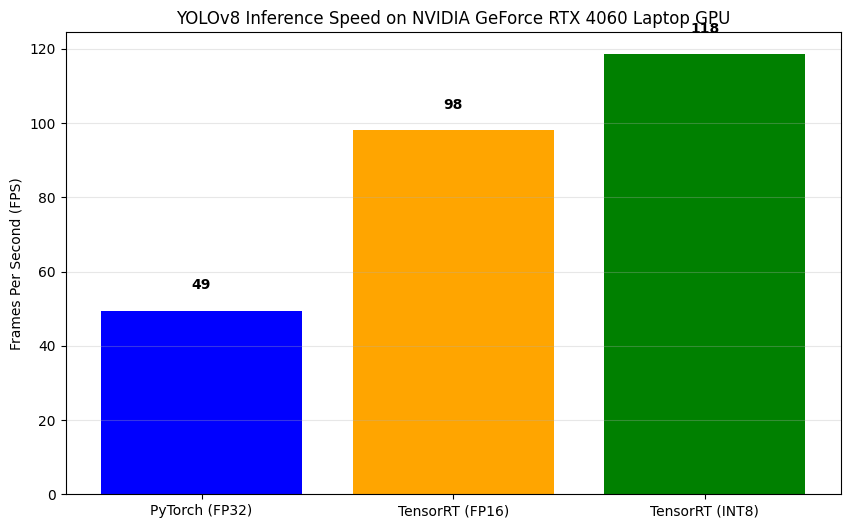

In [28]:
# Display Results Table
df = pd.DataFrame(list(results.items()), columns=['Model Format', 'FPS'])
df['Speedup (vs PyTorch)'] = df['FPS'] / results['PyTorch (FP32)']
print("\n🏆 FINAL BENCHMARK RESULTS 🏆")
print(df)

# Plot Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model Format'], df['FPS'], color=['blue', 'orange', 'green'])
plt.title(f"YOLOv8 Inference Speed on {torch.cuda.get_device_name(0)}")
plt.ylabel("Frames Per Second (FPS)")
plt.grid(axis='y', alpha=0.3)

# Add numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f"{int(yval)}", ha='center', va='bottom', fontweight='bold')

plt.savefig("benchmark_chart.png") # Save this image for your README
plt.show()